# Squashy Subreddit Demo


In [3]:
# Demo dependencies

# ! pip install netwulf
! pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.9.1.1-cp310-cp310-macosx_13_0_arm64.whl size=155637 sha256=261eb72ae16f31d915778460d8072761ac3750f4bf9e81792b2b4072880b7267
  Stored in directory: /Users/james/Library/Caches/pip/wheels/30/ea/66/ee489514316741d85dc783d0dbd46e987171f3e63d666b1e6c
Successfully built wordcloud

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Connect to Memgraph instance
from mini_memgraph import Memgraph

# Connect to instance
db = Memgraph(address='localhost', port=7687)


# WARNING!
This will replace all data in your memgraph instance. Please ensure you are using a new instance of Memgraph before proceeding.

# Loading the Data
The dataset is the Subreddit Hyperlink Network (body) available from [SNAP](https://snap.stanford.edu/data/soc-RedditHyperlinks.html).

Download the dataset from [SNAP](https://snap.stanford.edu/data/soc-RedditHyperlinks.html) and drop the .tsv into the same folder as this notebook.

```
@inproceedings{kumar2018community,
  title={Community interaction and conflict on the web},
  author={Kumar, Srijan and Hamilton, William L and Leskovec, Jure and Jurafsky, Dan},
  booktitle={Proceedings of the 2018 World Wide Web Conference on World Wide Web},
  pages={933--943},
  year={2018},
  organization={International World Wide Web Conferences Steering Committee}
}
```

In [7]:
data_path = 'soc-redditHyperlinks-body.tsv'

In [8]:
import pandas as pd
# Wipe existing data ready for import
db.write('MATCH (n) DETACH DELETE n')

# Set indexes
db.set_index('SUBREDDIT')
db.set_index('SUBREDDIT','id')
db.set_constraint('SUBREDDIT','id')

# Write all unique subreddit nodes
nodes = set()
with pd.read_csv(data_path, usecols=['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], sep='\t', chunksize=10000) as reader:
    for chunk in reader:
        nodes.update(chunk['SOURCE_SUBREDDIT'].tolist())
        nodes.update(chunk['TARGET_SUBREDDIT'].tolist())

node_list = [{'id':node} for node in list(nodes)]
db.write_nodes(node_list,id_val='id',label='SUBREDDIT')

# Write subreddit to subreddit link relations
# Edge frequencies are incremented for all duplicates found and saved as a 'weight' attribute
rename_cols = {'SOURCE_SUBREDDIT':'source','TARGET_SUBREDDIT':'target'}
with pd.read_csv(data_path,usecols=['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], sep='\t', chunksize=10000) as reader:
    for chunk in reader:
        edge_list = chunk.rename(columns=rename_cols).to_dict(orient='records')
        db.write_edges(edge_list,edge_label='LINKS_TO', source_label='SUBREDDIT',target_label='SUBREDDIT',
                      on_duplicate_edges='increment')


# Identify Core Nodes

In [188]:
import squashy

core_identifier = squashy.KCoreIdentifier(database=db,
                                          node_label='SUBREDDIT',
                                          rel_label='LINKS_TO',
                                          k=10,
                                          max_cores=500)
core_identifier.identify_core_nodes()

cores_identified:0 | graph_size:35,776 | n_remaining:35,776 | min_degree:1 | max_degree:2,524 | pass_:0 | loca…

TypeError: unsupported format string passed to NoneType.__format__

In [189]:
print(core_identifier.metrics._major_fields)

['cores_identified', 'graph_size', 'n_remaining', 'min_degree', 'max_degree', 'pass_']


In [190]:
fig = core_identifier.metrics.visualize(x='pass_',y='cores_identified')
fig.show()


# Assign Representatives

In [191]:
import squashy
agglomerator = squashy.GraphAgglomerator(database=db,
                                         node_label='SUBREDDIT',
                                         rel_label='LINKS_TO',
                                         weight='weight', # this was created when we loaded our data. You can also omit this argument to ignore weight when choosing representatives.
                                         min_hops=1,
                                         max_hops=2
                                         )

agglomerator.describe()

To traverse: (SUBREDDIT)-[LINKS_TO]-(SUBREDDIT)
To create: (CORE)-[REPRESENTS]->(SUBREDDIT)


In [192]:
agglomerator.reset()
agglomerator.agglomerate()

  0%|          | 0/698 [00:00<?, ?it/s]

In [4]:
agglomerator.set_maximum_hop(3)

In [5]:
agglomerator.agglomerate()

  0%|          | 0/500 [00:00<?, ?it/s]

pass_=1,015, graph_size=35,776, hop=3, n_cores=16, n_assigned=33,791, ratio=0.9445
Agglomeration incomplete.
Use .agglomerate() to restart hop 3.
Use .reset() to restart from the beginning


In [193]:
agglomerator.metrics.visualize(x='pass_', y='runtime', color='hop', log_y=True)

# Build Meta Relations

In [194]:
import squashy

meta_relate = squashy.MetaRelate(database=db,
                                 node_label='SUBREDDIT',
                                 rel_label='LINKS_TO',
                                 weight='weight')
meta_relate.reset()
meta_relate.build_meta_relations()

28607

In [195]:
meta_relate.count_meta_relations()

28607

In [196]:
meta_relate.cutoff_score

2.7450980392156863

In [197]:
meta_relate.score_ecdf()

# Examine Squashed Graph

In [198]:
edges = meta_relate.get_core_edge_list()
nodes = meta_relate.get_core_node_list()

In [199]:
n_squashed_nodes = len(nodes)
n_squashed_edges = len(edges)

In [200]:
n_raw_nodes = db.node_count('SUBREDDIT')

In [201]:
n_raw_edges = db.read('MATCH ()-[r:LINKS_TO]-() RETURN count(r) AS n_edges')[0]['n_edges']

In [202]:
print(f"Original Graph size: {n_raw_nodes:,} Nodes and {n_raw_edges:,} Edges")
print(f"Squashed Graph size: {n_squashed_nodes:,} Nodes and {n_squashed_edges:,} Edges")
print(f"Squashed Graph is {(n_squashed_nodes/n_raw_nodes)*100:.2}% of the original nodes & {(n_squashed_edges/n_raw_edges)*100:.2}% of the original edges ")


Original Graph size: 35,776 Nodes and 275,642 Edges
Squashed Graph size: 336 Nodes and 1,379 Edges
Squashed Graph is 0.94% of the original nodes & 0.5% of the original edges 


## Detect Communities

In [230]:
import networkx as nx
import pandas as pd
edge_list = pd.DataFrame(edges)
node_list = pd.DataFrame(nodes)

In [231]:
edge_list.head()

,source,target,weight,n_distinct,score
0,boogalized,blackhippy,14,8,5.090909
1,relationship_advice,teenagers,10,6,3.750000
2,raspberry_pi,diy,17,6,3.290323
3,askelectronics,diy,79,39,48.140625
4,buildapc,diy,33,22,3.821053


In [232]:
node_list.head()

,id,n_subnodes
0,boogalized,22
1,relationship_advice,16
2,nofap,99
3,subredditdrama,2064
4,askreddit,2362


In [233]:
G = nx.from_pandas_edgelist(edge_list,edge_attr=True, create_using=nx.DiGraph)

node_attr = node_list.set_index('id').rename(columns={'n_subnodes':'size'}).to_dict(orient='index')
nx.set_node_attributes(G, node_attr)

In [234]:
G.number_of_nodes()

336

In [235]:
G.number_of_edges()

1379

In [236]:
components = nx.components.connected_components(G.to_undirected())
giant_component = sorted(components, key=len, reverse=True)[0]
len(giant_component)

G = nx.subgraph(G,giant_component)

In [237]:
RESOLUTION = 0.4

communities = nx.algorithms.community.louvain_communities(G,weight='score', resolution=RESOLUTION)
modularity_score = nx.algorithms.community.modularity(G,communities,weight='score', resolution=RESOLUTION)


print(f"N Communities: {len(communities)} - Modularity: {modularity_score:.3}")

N Communities: 40 - Modularity: 0.778


In [238]:
com_to_assign = {}
for i, community in enumerate(communities):
    for member in community:
        com_to_assign[member] = i
com_to_assign

{'octobersveryown': 0,
 'popheadscirclejerk': 0,
 'blackhippy': 0,
 'kidcudi': 0,
 'boogalized': 0,
 'theweeknd': 0,
 'lilyachty': 0,
 '21savage': 0,
 'frankocean': 0,
 'kendricklamar': 0,
 'ofwgkta': 0,
 'kanye': 0,
 'relationship_advice': 1,
 'raisedbynarcissists': 1,
 'relationships': 1,
 'mgtow': 1,
 'diy': 2,
 'askelectronics': 2,
 'fitness': 3,
 'keto': 3,
 'loseit': 3,
 'nofap': 4,
 'getdisciplined': 4,
 'seahawks': 5,
 'redskins': 5,
 'colts': 5,
 'cowboys': 5,
 'tennesseetitans': 5,
 'greenbaypackers': 5,
 'ravens': 5,
 'kansascitychiefs': 5,
 'minnesotavikings': 5,
 'denverbroncos': 5,
 'nfl_draft': 5,
 'texans': 5,
 'detroitlions': 5,
 'buccaneers': 5,
 'eagles': 5,
 'azcardinals': 5,
 'buffalobills': 5,
 'losangelesrams': 5,
 'nygiants': 5,
 'chargers': 5,
 'bengals': 5,
 '49ers': 5,
 'nfl': 5,
 'miamidolphins': 5,
 'panthers': 5,
 'chibears': 5,
 'browns': 5,
 'saints': 5,
 'books': 6,
 'fantasy': 6,
 'leafs': 7,
 'hockey': 7,
 'wildhockey': 7,
 'stlouisblues': 7,
 'askwom

In [239]:
sizes = node_list.set_index('id')['n_subnodes'].to_dict()

In [240]:
nx.set_node_attributes(G,sizes,'size')
nx.set_node_attributes(G,com_to_assign,'group')

In [241]:
import netwulf as nw

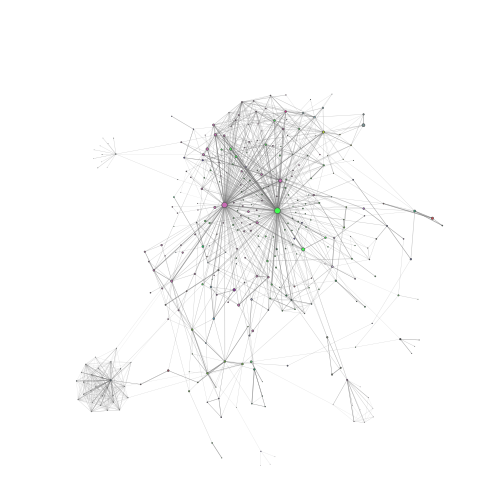

In [242]:
fig, config = nw.visualize(G)

# Community Groups

In [243]:
node_list = node_list.merge(pd.Series(com_to_assign, name='community'), how='left', left_on='id', right_index=True)

<Axes: ylabel='Frequency'>

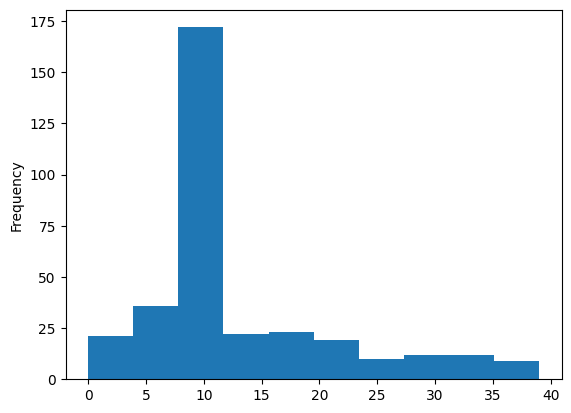

In [244]:
node_list['community'].plot(kind='hist')

In [245]:
node_list.groupby('community')['n_subnodes'].sum().sort_values(ascending=False)


community
10    11627
11     9094
16     1085
27      705
26      570
20      541
18      530
19      527
29      468
28      457
23      444
35      421
3       370
36      359
22      345
12      338
34      335
21      301
2       297
24      295
6       289
33      286
9       252
31      228
1       219
25      216
5       213
17      198
7       165
14      149
13      145
32      141
38      139
4       132
8       125
37       76
39       60
0        56
30       36
15       24
Name: n_subnodes, dtype: int64

In [246]:
TOP_N = 30

top_comms =node_list.groupby('community')['n_subnodes'].sum().sort_values(ascending=False).head(TOP_N).index.tolist()


In [247]:
node_list

,id,n_subnodes,community
0,boogalized,22,0
1,relationship_advice,16,1
2,nofap,99,4
3,subredditdrama,2064,10
4,askreddit,2362,11
...,...,...,...
331,tumblrinaction,20,10
332,rpg,121,35
333,askwomen,13,8
334,philosophy,34,39


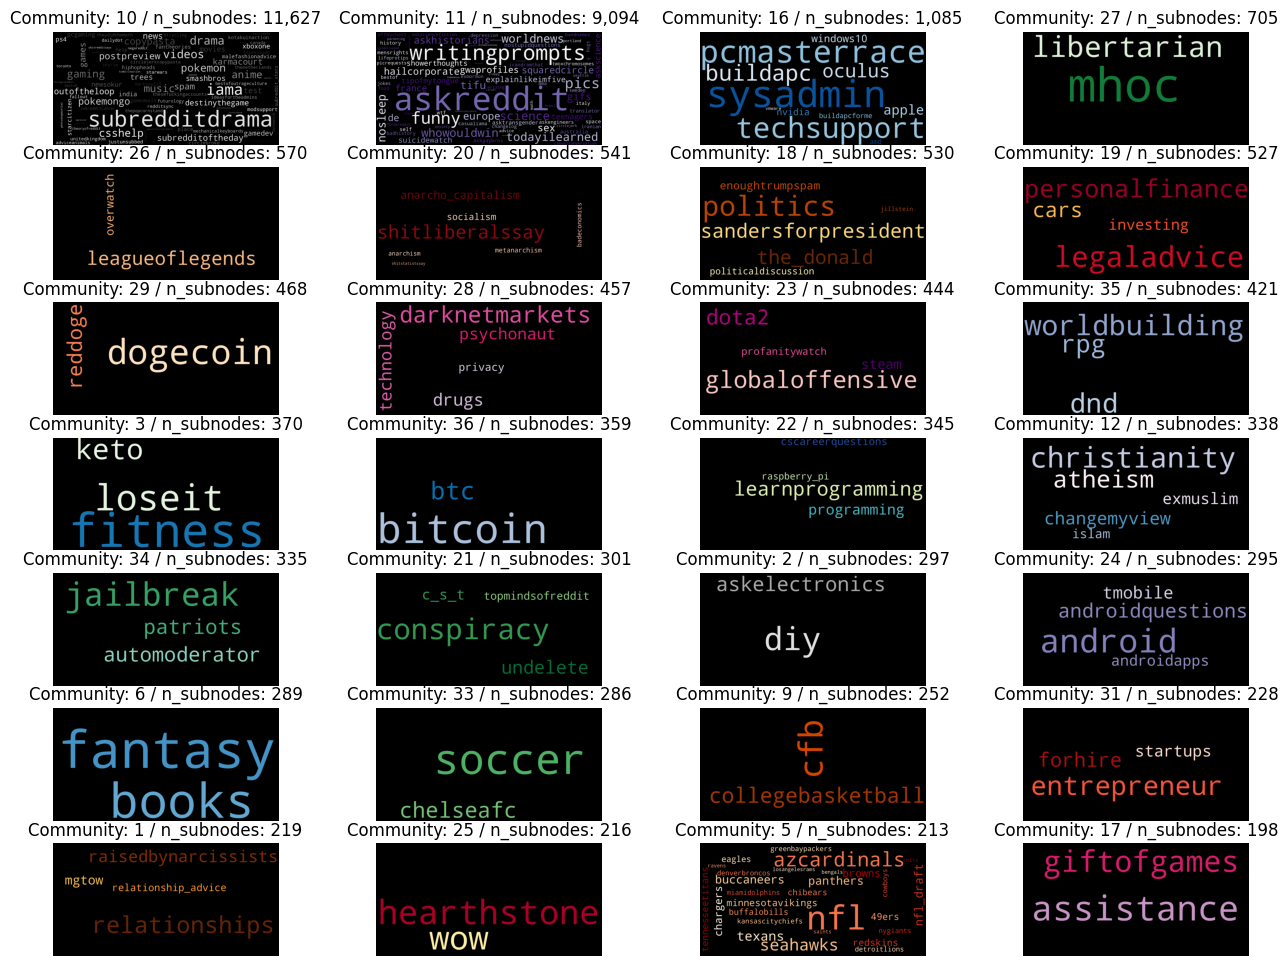

In [248]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(int(TOP_N/4),4, figsize=(16,12))
axes = axes.flat

colours = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                          'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                          'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

counts = node_list.groupby('community')['n_subnodes'].sum()

from itertools import cycle
for community, cmap, ax in zip(top_comms, cycle(colours), axes):
    subset = node_list.query(f'community == {community}')
    scores = subset.set_index('id')['n_subnodes'].to_dict()
    wc = WordCloud(colormap=cmap,
                       width=2048,height=1024,
                       background_color='black').generate_from_frequencies(scores)
    ax.imshow(wc)
    ax.axis('off')
    ax.title.set_text(f'Community: {community} / n_subnodes: {counts.loc[community]:,}')

